In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


In [3]:
@njit
def normalized_energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum(((X[i]-y)/y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum(((X[i]-X[j])/y)**2))/(2*N**2)
    return ES

In [4]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions



In [5]:
def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [6]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations

,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-03-16,02,Alaska,8,1.124502
1,2,2024-03-16,01,Alabama,81,1.599596
2,3,2024-03-16,05,Arkansas,188,6.180393
3,4,2024-03-16,04,Arizona,134,1.825360
4,5,2024-03-16,06,California,185,0.475743
...,...,...,...,...,...,...
5825,5826,2022-02-12,50,Vermont,0,0.000000
5826,5827,2022-02-12,53,Washington,8,0.103415
5827,5828,2022-02-12,55,Wisconsin,29,0.492275
5828,5829,2022-02-12,54,West Virginia,5,0.281694


In [7]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4


In [8]:
predictionsall = pd.DataFrame()
for model in models:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    print(model, len(df.location.unique()))
    
    predictionsall = pd.concat([predictionsall, df])

CADPH-FluCAT 1
CDDEP-FluCompModel 1
Ensemble 57
Ensemble_LOP 57
Ensemble_LOP_untrimmed 57
MOBS_NEU-GLEAM_FLU 52
NIH-FluD 1
NIH-Flu_TS 13
NotreDame-FRED 52
PSI-M2 52
USC-SIkJalpha 57
UT-ImmunoSEIRS 51
UVA-FluXSim 1


In [9]:
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

predictionsall = predictionsall[~predictionsall['Model'].isin(singleloc_models)]

In [10]:
# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]

In [15]:
# only look at MOBS trajectories and for full US

predictions_mobs = predictions_traj[(predictions_traj.Model == 'MOBS_NEU-GLEAM_FLU') & \
                                    (predictions_traj.location == 'US')]

In [16]:
predictions_mobs

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date
198900,2023-09-03,A-2023-08-14,inc hosp,1.0,US,sample,1.0,0-130,579.000,MOBS_NEU-GLEAM_FLU,2023-09-09
198901,2023-09-03,A-2023-08-14,inc hosp,2.0,US,sample,1.0,0-130,583.000,MOBS_NEU-GLEAM_FLU,2023-09-16
198902,2023-09-03,A-2023-08-14,inc hosp,3.0,US,sample,1.0,0-130,666.000,MOBS_NEU-GLEAM_FLU,2023-09-23
198903,2023-09-03,A-2023-08-14,inc hosp,4.0,US,sample,1.0,0-130,194.000,MOBS_NEU-GLEAM_FLU,2023-09-30
198904,2023-09-03,A-2023-08-14,inc hosp,5.0,US,sample,1.0,0-130,647.000,MOBS_NEU-GLEAM_FLU,2023-10-07
...,...,...,...,...,...,...,...,...,...,...,...
1470283,2023-09-03,F-2023-08-14,inc hosp,23.0,US,sample,100.0,0-130,2886.938,MOBS_NEU-GLEAM_FLU,2024-02-10
1470284,2023-09-03,F-2023-08-14,inc hosp,24.0,US,sample,100.0,0-130,3691.810,MOBS_NEU-GLEAM_FLU,2024-02-17
1470285,2023-09-03,F-2023-08-14,inc hosp,25.0,US,sample,100.0,0-130,3749.501,MOBS_NEU-GLEAM_FLU,2024-02-24
1470286,2023-09-03,F-2023-08-14,inc hosp,26.0,US,sample,100.0,0-130,4279.784,MOBS_NEU-GLEAM_FLU,2024-03-02


In [29]:
locations = pd.read_csv('/Users/bay.c/Documents/GitHub/energy-score/dat/locations.csv',dtype={'location':str})


In [71]:
model = 'MOBS_NEU-GLEAM_FLU'
loc = 'US'
ES_scen = {}
for scenario_best in ['A', 'B', 'C', 'D', 'E', 'F']:

    energyscoresdf = pd.DataFrame()
    for it in range(200):
        #pick random trajectory
        truth = random.randint(1, 100)

        # assume scenario A is best, pick ground truth trajectory
        truth_trajectory = predictions_mobs[(predictions_mobs.scenario_id == scenario_best + '-2023-08-14') &\
                                            (predictions_mobs.output_type_id == truth)]

        all_trajectory = predictions_mobs.copy()

        # calculate energy score of each scenario against our ground truth trajectory
        observations = truth_trajectory.copy()
        observations['target_end_date'] = pd.to_datetime(observations['target_end_date'])


        start_week = pd.to_datetime('2023-09-09')
        max_date = pd.to_datetime(observations.target_end_date.max())


        predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

        for scenario in all_trajectory.scenario_id.unique():    
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs



            predictionsfilt = all_trajectory[(all_trajectory.scenario_id == scenario ) & \
                                        (all_trajectory.target_end_date <= max_date) & \
                                        (all_trajectory.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue

            observations = observations[(observations['target_end_date'] >= start_week) & \
                                        (observations['target_end_date'] <= max_date)]   


            #transform to Observation object
            observations = Observations(observations, t_col='target_end_date')


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['output_type_id'] == i].value) for i in predictionsfilt['output_type_id'].unique()]

            ES = energyscore(np.array(X),y)


            newrow = pd.DataFrame({'Model':model,'Label': scenario, 'location':loc, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

    energyscoresdf = energyscoresdf.reset_index()
    energyscoresdf = energyscoresdf.drop(columns=['index'])   
    
    ES_scen[scenario_best] = energyscoresdf


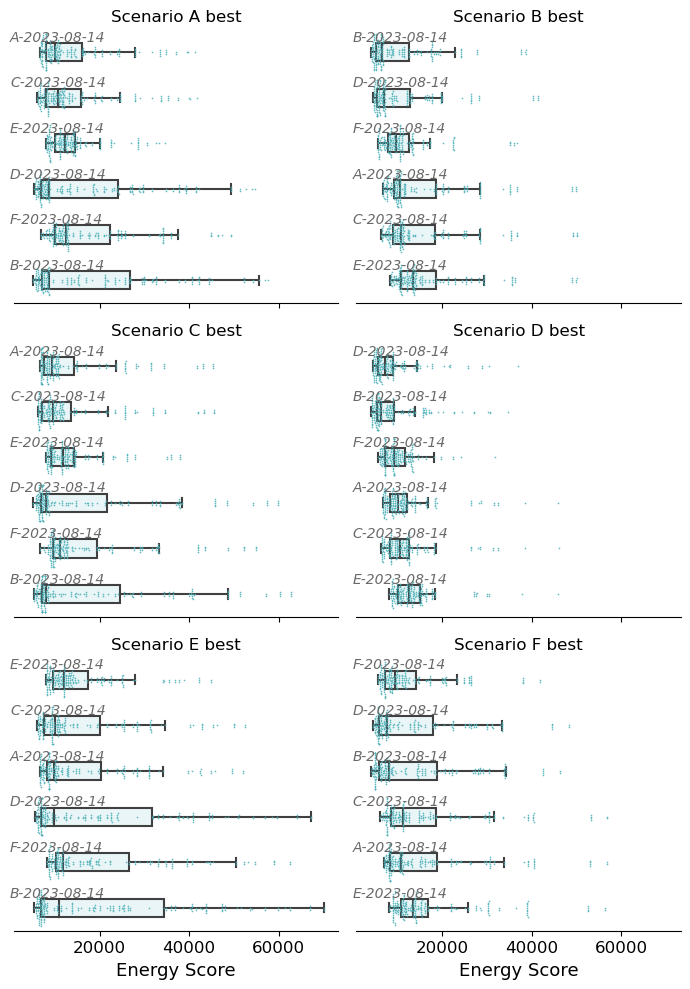

In [72]:
fig = plt.subplots(3,2,figsize=(7, 10), sharex=True)

j=1
for scenario in ES_scen.keys():
    ax = plt.subplot(3,2,j)
    
    df = ES_scen[scenario]

    #wistraj = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp.pkl")

    my_order = df.groupby(by=['Label'])['energyscore'].mean().sort_values(ascending=True).index
    g = sns.boxplot(x='energyscore', y='Label', data=df,order=my_order, color = '#17B1BF',
                    width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='energyscore', y='Label', data=df,order=my_order,color = "#49AFB7",
                  alpha = .85,size=1.2, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Energy Score', fontsize=13)
    else:
        plt.xlabel('')
    plt.xticks(fontsize=12)

    plt.title('Scenario '+scenario +' best')

    a = 0
    for mod in list(my_order):
        plt.text(.85,a-.25, mod, fontsize=10, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # plt.xlim([0,110]) # cuts off some outliers
    
    j+=1

plt.tight_layout()
#plt.savefig(' ')
plt.show()

In [78]:
# calculate WIS from trajectories
model = 'MOBS_NEU-GLEAM_FLU'
loc = 'US'
WIS_scen = {}
for scenario_best in ['A', 'B', 'C', 'D', 'E', 'F']:

    wisdf_traj = pd.DataFrame()
    for it in range(200):
        #pick random trajectory
        truth = random.randint(1, 100)

        # assume scenario A is best, pick ground truth trajectory
        truth_trajectory = predictions_mobs[(predictions_mobs.scenario_id == scenario_best + '-2023-08-14') &\
                                            (predictions_mobs.output_type_id == truth)]

        all_trajectory = predictions_mobs.copy()

        # calculate energy score of each scenario against our ground truth trajectory
        observations = truth_trajectory.copy()
        observations['target_end_date'] = pd.to_datetime(observations['target_end_date'])


        start_week = pd.to_datetime('2023-09-09')
        max_date = pd.to_datetime(observations.target_end_date.max())


        predictions_traj['target_end_date'] = pd.to_datetime(predictions_traj['target_end_date'])

        for scenario in all_trajectory.scenario_id.unique():    
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs



            predictionsfilt = all_trajectory[(all_trajectory.scenario_id == scenario ) & \
                                        (all_trajectory.target_end_date <= max_date) & \
                                        (all_trajectory.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue

            observations = observations[(observations['target_end_date'] >= start_week) & \
                                        (observations['target_end_date'] <= max_date)]   


            #transform to Observation object
            observations =  Observations(observations, t_col='target_end_date')

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.output_type_id == i].value) \
                            for i in predictionsfilt.output_type_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)

            WIS = np.mean(WIS) / (len(quantiles) // 2 + 0.5)

            
            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': scenario, 'location':loc, 'WIS':WIS, 
                                'target':target}, index=[0])

            wisdf_traj = pd.concat([wisdf_traj, newrow])



    wisdf_traj = wisdf_traj.reset_index()
    wisdf_traj = wisdf_traj.drop(columns=['index'])   
    
    WIS_scen[scenario_best] = wisdf_traj



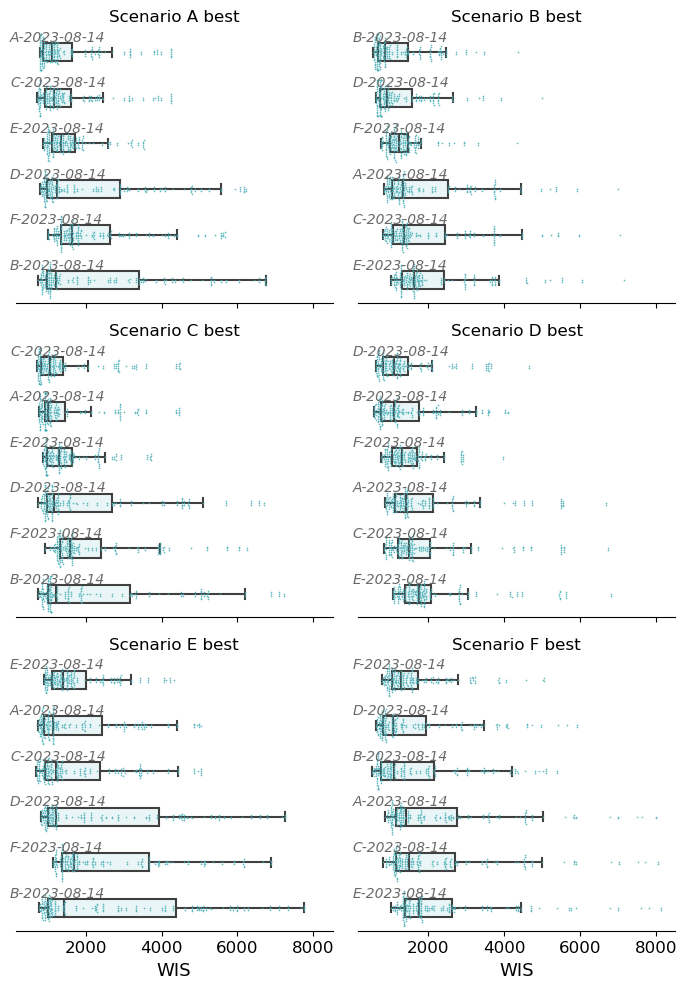

In [80]:
fig = plt.subplots(3,2,figsize=(7, 10), sharex=True)

j=1
for scenario in WIS_scen.keys():
    ax = plt.subplot(3,2,j)
    
    df = WIS_scen[scenario]

    #wistraj = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp.pkl")

    my_order = df.groupby(by=['Label'])['WIS'].mean().sort_values(ascending=True).index
    g = sns.boxplot(x='WIS', y='Label', data=df,order=my_order, color = '#17B1BF',
                    width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='WIS', y='Label', data=df,order=my_order,color = "#49AFB7",
                  alpha = .85,size=1.2, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('WIS', fontsize=13)
    else:
        plt.xlabel('')
    plt.xticks(fontsize=12)

    plt.title('Scenario '+scenario +' best')

    a = 0
    for mod in list(my_order):
        plt.text(.85,a-.25, mod, fontsize=10, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # plt.xlim([0,110]) # cuts off some outliers
    
    j+=1

plt.tight_layout()
#plt.savefig(' ')
plt.show()

# try this for trajectory ensemble

In [11]:
# include all models, even those only submitting for one location
modelsall = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 
             'NotreDame-FRED','PSI-M2', 'USC-SIkJalpha', 'UT-ImmunoSEIRS', 'UVA-FluXSim']


start_week = pd.to_datetime('2023-09-09')
#max_date = pd.to_datetime(observations.date.max())



predictionsall = pd.DataFrame()
i=0
for model in modelsall:
    df = pd.read_parquet(f'/Users/bay.c/Documents/GitHub/energy-score/fludat/{model}_rd4.pq')
    # filter by trajectories and only look at age group with all ages combined
    df = df[(df.output_type == 'sample') & (df.age_group == '0-130')]
    df['output_type_id'] = df['output_type_id'].astype("int")
    
    df['Model'] = model
    df['trajectory_id'] = df['output_type_id'] + 100*i
    predictionsall = pd.concat([predictionsall, df])
    i += 1
    

In [12]:
predictionsall

,origin_date,scenario_id,target,horizon,location,output_type,output_type_id,age_group,value,Model,target_end_date,trajectory_id
0,2023-09-03 00:00:00,B-2023-08-14,inc hosp,1.0,06,sample,1,0-130,48.000000,CADPH-FluCAT,2023-09-09,1
1,2023-09-03 00:00:00,B-2023-08-14,inc hosp,2.0,06,sample,1,0-130,45.000000,CADPH-FluCAT,2023-09-16,1
2,2023-09-03 00:00:00,B-2023-08-14,inc hosp,3.0,06,sample,1,0-130,86.000000,CADPH-FluCAT,2023-09-23,1
3,2023-09-03 00:00:00,B-2023-08-14,inc hosp,4.0,06,sample,1,0-130,109.000000,CADPH-FluCAT,2023-09-30,1
4,2023-09-03 00:00:00,B-2023-08-14,inc hosp,5.0,06,sample,1,0-130,187.000000,CADPH-FluCAT,2023-10-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23395,2023-09-03,F-2023-08-14,inc hosp,39.0,US,sample,96,0-130,0.736458,UVA-FluXSim,2024-06-01,996
23396,2023-09-03,F-2023-08-14,inc hosp,39.0,US,sample,97,0-130,0.785018,UVA-FluXSim,2024-06-01,997
23397,2023-09-03,F-2023-08-14,inc hosp,39.0,US,sample,98,0-130,2.580718,UVA-FluXSim,2024-06-01,998
23398,2023-09-03,F-2023-08-14,inc hosp,39.0,US,sample,99,0-130,0.911499,UVA-FluXSim,2024-06-01,999


In [30]:
loc = 'US'
ES_scen = {}

predall = predictionsall[predictionsall.location==loc]
for scenario_best in ['A', 'B', 'C', 'D', 'E', 'F']:

    energyscoresdf = pd.DataFrame()
    for it in range(100):
        #pick random trajectory
        truth = random.choice(list(predall.trajectory_id.unique()))

        # assume scenario A is best, pick ground truth trajectory
        truth_trajectory = predall[(predall.scenario_id == scenario_best + '-2023-08-14') &\
                                            (predall.trajectory_id == truth)]

        all_trajectory = predall.copy()

        # calculate energy score of each scenario against our ground truth trajectory
        observations = truth_trajectory.copy()
        observations['target_end_date'] = pd.to_datetime(observations['target_end_date'])


        start_week = pd.to_datetime('2023-09-09')
        max_date = pd.to_datetime(observations.target_end_date.max())


        for scenario in all_trajectory.scenario_id.unique():    
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs



            predictionsfilt = all_trajectory[(all_trajectory.scenario_id == scenario ) & \
                                        (all_trajectory.target_end_date <= max_date) & \
                                        (all_trajectory.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue

            observations = observations[(observations['target_end_date'] >= start_week) & \
                                        (observations['target_end_date'] <= max_date)]   


            #transform to Observation object
            observations = Observations(observations, t_col='target_end_date')


            y = np.array(observations.value)
            X = [np.array(predictionsfilt[predictionsfilt['trajectory_id'] == i].value) for i in predictionsfilt['trajectory_id'].unique()]

            ES = energyscore(np.array(X),y)


            newrow = pd.DataFrame({'Model':'Trajectory Ensemble','Label': scenario, 'location':loc, 'energyscore':ES, 
                                'target':target}, index=[0])

            energyscoresdf = pd.concat([energyscoresdf, newrow])

    energyscoresdf = energyscoresdf.reset_index()
    energyscoresdf = energyscoresdf.drop(columns=['index'])   
    
    ES_scen[scenario_best] = energyscoresdf


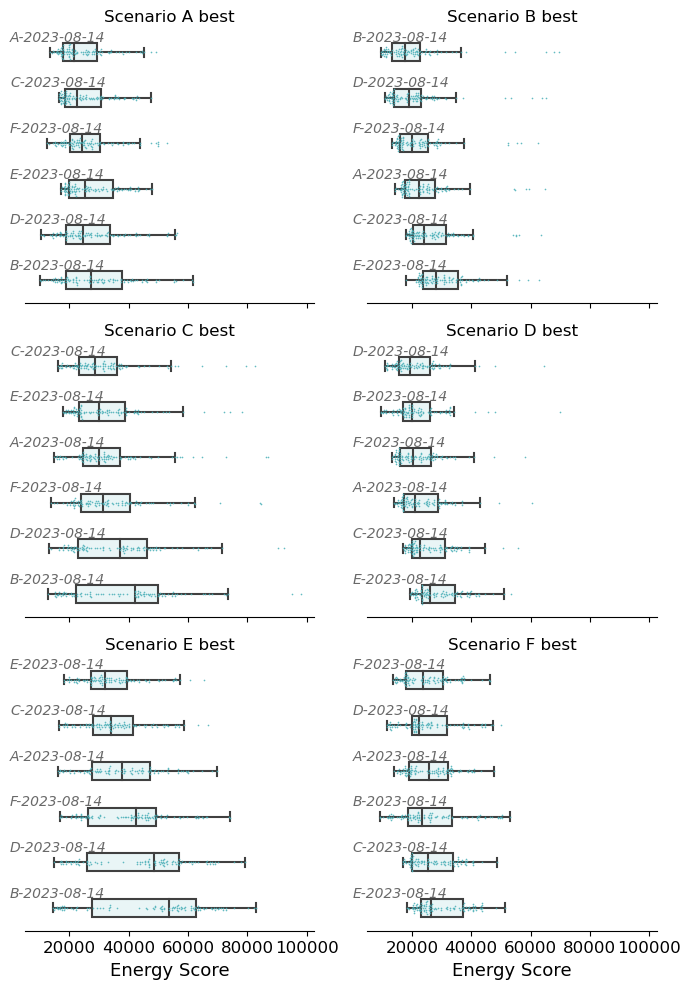

In [31]:
fig = plt.subplots(3,2,figsize=(7, 10), sharex=True)

j=1
for scenario in ES_scen.keys():
    ax = plt.subplot(3,2,j)
    
    df = ES_scen[scenario]

    #wistraj = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp.pkl")

    my_order = df.groupby(by=['Label'])['energyscore'].mean().sort_values(ascending=True).index
    g = sns.boxplot(x='energyscore', y='Label', data=df,order=my_order, color = '#17B1BF',
                    width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='energyscore', y='Label', data=df,order=my_order,color = "#49AFB7",
                  alpha = .85,size=1.2, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('Energy Score', fontsize=13)
    else:
        plt.xlabel('')
    plt.xticks(fontsize=12)

    plt.title('Scenario '+scenario +' best')

    a = 0
    for mod in list(my_order):
        plt.text(.85,a-.25, mod, fontsize=10, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # plt.xlim([0,110]) # cuts off some outliers
    
    j+=1

plt.tight_layout()
#plt.savefig(' ')
plt.show()

In [34]:
loc = 'US'
WIS_scen = {}

predall = predictionsall[predictionsall.location==loc]
for scenario_best in ['A', 'B', 'C', 'D', 'E', 'F']:

    wisdf_traj = pd.DataFrame()
    for it in range(100):
        #pick random trajectory
        truth = random.choice(list(predall.trajectory_id.unique()))

        # assume scenario A is best, pick ground truth trajectory
        truth_trajectory = predall[(predall.scenario_id == scenario_best + '-2023-08-14') &\
                                            (predall.trajectory_id == truth)]

        all_trajectory = predall.copy()

        # calculate energy score of each scenario against our ground truth trajectory
        observations = truth_trajectory.copy()
        observations['target_end_date'] = pd.to_datetime(observations['target_end_date'])


        start_week = pd.to_datetime('2023-09-09')
        max_date = pd.to_datetime(observations.target_end_date.max())


        for scenario in all_trajectory.scenario_id.unique():    
            target = 'hosp'
            incidence = True

            if target == 'hosp':
                target_obs = 'hospitalization'
            else:
                target_obs = target_obs



            predictionsfilt = all_trajectory[(all_trajectory.scenario_id == scenario ) & \
                                        (all_trajectory.target_end_date <= max_date) & \
                                        (all_trajectory.target_end_date >= start_week)]

            if len(predictionsfilt) == 0:
                print(f'no predictions for {model} at location {loc} for scenario {scenario}')
                continue

            observations = observations[(observations['target_end_date'] >= start_week) & \
                                        (observations['target_end_date'] <= max_date)]   


            #transform to Observation object
            observations =  Observations(observations, t_col='target_end_date')

            y = np.array(observations.value)
            X = np.array([np.array(predictionsfilt[predictionsfilt.trajectory_id == i].value) \
                            for i in predictionsfilt.trajectory_id.unique()])

            quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,
                        0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]

            # get quantiles
            Q = np.quantile(X,quantiles,axis=0)

            # calculate WIS
            WIS = np.zeros(X.shape[1])
            for i in range(len(quantiles) // 2):
                interval_range = 100*(quantiles[-i-1]-quantiles[i])
                alpha = 1-(quantiles[-i-1]-quantiles[i])
                IS = interval_score(y,Q[i],Q[-i-1],interval_range)
                WIS += IS['interval_score']*alpha/2
            WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)

            WIS = np.mean(WIS) / (len(quantiles) // 2 + 0.5)

            
            # save into dataframe
            newrow = pd.DataFrame({'Model':model , 'Label': scenario, 'location':loc, 'WIS':WIS, 
                                'target':target}, index=[0])

            wisdf_traj = pd.concat([wisdf_traj, newrow])



    wisdf_traj = wisdf_traj.reset_index()
    wisdf_traj = wisdf_traj.drop(columns=['index'])   
    
    WIS_scen[scenario_best] = wisdf_traj



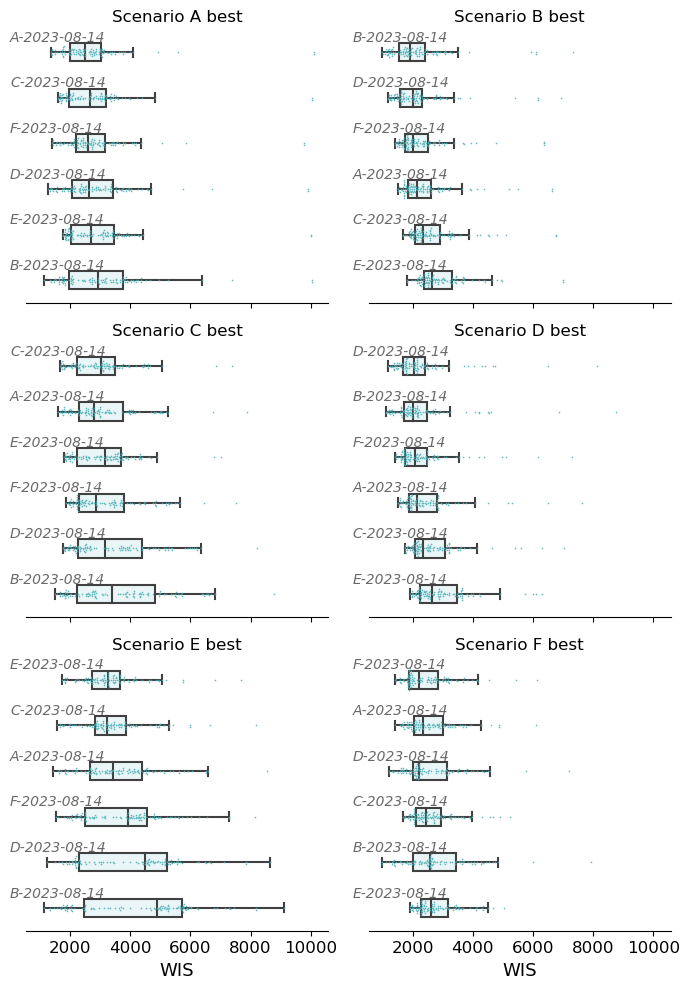

In [35]:
fig = plt.subplots(3,2,figsize=(7, 10), sharex=True)

j=1
for scenario in WIS_scen.keys():
    ax = plt.subplot(3,2,j)
    
    df = WIS_scen[scenario]

    #wistraj = pd.read_pickle("/Users/bay.c/Documents/GitHub/energy-score/fludat/wis_trajectory_ensemble_rd4_hosp.pkl")

    my_order = df.groupby(by=['Label'])['WIS'].mean().sort_values(ascending=True).index
    g = sns.boxplot(x='WIS', y='Label', data=df,order=my_order, color = '#17B1BF',
                    width=.4, showfliers=False)

    for patch in ax.patches:
        r, gr, b, a = patch.get_facecolor()
        patch.set_facecolor((r, gr, b, .1))


    sns.swarmplot(x='WIS', y='Label', data=df,order=my_order,color = "#49AFB7",
                  alpha = .85,size=1.2, orient="h")    

    g.set(ylabel=None)
    g.set(yticklabels=[])
    g.set(yticks=[])

    if j in [5,6]:
        plt.xlabel('WIS', fontsize=13)
    else:
        plt.xlabel('')
    plt.xticks(fontsize=12)

    plt.title('Scenario '+scenario +' best')

    a = 0
    for mod in list(my_order):
        plt.text(.85,a-.25, mod, fontsize=10, style='italic', color='dimgray')
        a+=1

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # plt.xlim([0,110]) # cuts off some outliers
    
    j+=1

plt.tight_layout()
#plt.savefig(' ')
plt.show()